# A Speech Recognition Model inspired by DeepSpeech 2

In [ ]:
! pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 50.6 MB/s eta 0:00:00


In [ ]:
import os
from google.colab import drive

def create_directory_if_not_exists(directory_path: str) -> None:
    assert directory_path is not None
    assert len(directory_path) != 0
    if os.path.isdir(directory_path):
        print(directory_path, 'exists, so it doesn\'t need to be created')
    else:
        os.makedirs(directory_path)
        print(directory_path, 'didn\'t exists and has just created')

drive.mount('/content/drive')

DATA_PATH = '/content/data'
create_directory_if_not_exists(DATA_PATH)

Mounted at /content/drive
/content/data didn't exists and has just created


In [ ]:
from pathlib import Path

from IPython.display import display, Audio
import jiwer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
gpu_device_list = tf.config.list_physical_devices('GPU')
device = 'gpu:0' if len(gpu_device_list) != 0 else 'cpu'
print('Current device is', device, f'({len(gpu_device_list)} GPU found)')

Current device is gpu:0 (1 GPU found)


## Load data

LJSpeech dataset ([here](https://keithito.com/LJ-Speech-Dataset/), 7 minutes to download and untar)

In [ ]:
temp_path = keras.utils.get_file(
    origin='https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2',
    untar=False,
    cache_dir=DATA_PATH
)       # Flag untar=True is super slow, so I'll pass

print(DATA_PATH)
print(temp_path)

2748572632/2748572632 [==============================] - 74s 0us/step
/content/data
/content/data/datasets/LJSpeech-1.1.tar.bz2


In [ ]:
! tar -xvf {temp_path} -C {DATA_PATH}

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
LJSpeech-1.1/wavs/LJ022-0089.wav
LJSpeech-1.1/wavs/LJ030-0192.wav
LJSpeech-1.1/wavs/LJ041-0078.wav
LJSpeech-1.1/wavs/LJ045-0249.wav
LJSpeech-1.1/wavs/LJ034-0035.wav
LJSpeech-1.1/wavs/LJ010-0152.wav
LJSpeech-1.1/wavs/LJ036-0174.wav
LJSpeech-1.1/wavs/LJ035-0076.wav
LJSpeech-1.1/wavs/LJ032-0176.wav
LJSpeech-1.1/wavs/LJ046-0113.wav
LJSpeech-1.1/wavs/LJ017-0096.wav
LJSpeech-1.1/wavs/LJ004-0098.wav
LJSpeech-1.1/wavs/LJ010-0147.wav
LJSpeech-1.1/wavs/LJ042-0230.wav
LJSpeech-1.1/wavs/LJ041-0033.wav
LJSpeech-1.1/wavs/LJ045-0229.wav
LJSpeech-1.1/wavs/LJ014-0199.wav
LJSpeech-1.1/wavs/LJ002-0082.wav
LJSpeech-1.1/wavs/LJ006-0055.wav
LJSpeech-1.1/wavs/LJ045-0120.wav
LJSpeech-1.1/wavs/LJ050-0028.wav
LJSpeech-1.1/wavs/LJ045-0215.wav
LJSpeech-1.1/wavs/LJ013-0121.wav
LJSpeech-1.1/wavs/LJ008-0025.wav
LJSpeech-1.1/wavs/LJ005-0240.wav
LJSpeech-1.1/wavs/LJ044-0026.wav
LJSpeech-1.1/wavs/LJ048-0127.wav
LJSpeech-1.1/wavs/LJ006-0195.wav
LJSpeech-1.1/wavs/L

In [ ]:
wav_dir_path = str(Path(DATA_PATH, 'LJSpeech-1.1', 'wavs'))
metadata_path = str(Path(DATA_PATH, 'LJSpeech-1.1', 'metadata.csv'))

print(wav_dir_path)
print(metadata_path)

/content/data/LJSpeech-1.1/wavs
/content/data/LJSpeech-1.1/metadata.csv


In [ ]:
metadata_df = pd.read_csv(metadata_path, sep='|', header=None, quoting=3)
metadata_df.columns = ['file_name', 'transcription', 'normalized_transcription']
# metadata_df.file_name = str(Path(wav_dir_path, metadata_df.file_name).with_suffix('.wav'))
metadata_df.file_name = [f'{wav_dir_path}/{file_name}.wav' for file_name in metadata_df.file_name]
metadata_df

,file_name,transcription,normalized_transcription
0,/content/data/LJSpeech-1.1/wavs/LJ001-0001.wav,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ..."
1,/content/data/LJSpeech-1.1/wavs/LJ001-0002.wav,in being comparatively modern.,in being comparatively modern.
2,/content/data/LJSpeech-1.1/wavs/LJ001-0003.wav,For although the Chinese took impressions from...,For although the Chinese took impressions from...
3,/content/data/LJSpeech-1.1/wavs/LJ001-0004.wav,"produced the block books, which were the immed...","produced the block books, which were the immed..."
4,/content/data/LJSpeech-1.1/wavs/LJ001-0005.wav,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...
...,...,...,...
13095,/content/data/LJSpeech-1.1/wavs/LJ050-0274.wav,made certain recommendations which it believes...,made certain recommendations which it believes...
13096,/content/data/LJSpeech-1.1/wavs/LJ050-0275.wav,materially improve upon the procedures in effe...,materially improve upon the procedures in effe...
13097,/content/data/LJSpeech-1.1/wavs/LJ050-0276.wav,"As has been pointed out, the Commission has no...","As has been pointed out, the Commission has no..."
13098,/content/data/LJSpeech-1.1/wavs/LJ050-0277.wav,with the active cooperation of the responsible...,with the active cooperation of the responsible...


In [ ]:
# test_size = 0.4
# test_mask = np.random.rand(len(metadata_df)) < test_size
# train_metadata_df = metadata_df[~test_mask]
# test_metadata_df = metadata_df[test_mask]
# print('Size of train dataset:', len(train_metadata_df))
# print('Size of test dataset:', len(test_metadata_df))
# print()
# print(
#     'First row of train dataset:\n' +
#     train_metadata_df['file_name'].iloc[0] + '\n' +
#     train_metadata_df['transcription'].iloc[0] + '\n' +
#     train_metadata_df['normalized_transcription'].iloc[0] + '\n'
# )

In [ ]:
train_metadata_df, valid_metadata_df, test_metadata_df = np.split(
    metadata_df.sample(frac=1, random_state=230713),
    [int(0.8 * len(metadata_df)), int(0.9 * len(metadata_df))]
)

## Pre-process data

We need to prepare a character set.

In [ ]:
char_list = [
    '-', ' ', 'E', 'T', 'A',
    'O', 'N', 'I', 'H', 'S',
    'R', 'D', 'L', 'U', 'M',
    'W', 'C', 'F', 'G', 'Y',
    'P', 'B', 'V', 'K', "'",
    'X', 'J', 'Q', 'Z', '?',
    '!', '.', ','
]
# Maps character to integer
char_to_num = layers.StringLookup(vocabulary=char_list, oov_token='')
# Maps integer to character
num_to_char = layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token='', invert=True)

print('There are', char_to_num.vocabulary_size(), 'characters')
for i, c in enumerate(char_to_num.get_vocabulary()):
    if c != '':
        print(f'\t___{c}___', end='')
    else:
        print('\t_EMPTY_', end='')
    if i % 5 == 4:
        print()
print()

There are 34 characters
	_EMPTY_	___-___	___ ___	___E___	___T___
	___A___	___O___	___N___	___I___	___H___
	___S___	___R___	___D___	___L___	___U___
	___M___	___W___	___C___	___F___	___G___
	___Y___	___P___	___B___	___V___	___K___
	___'___	___X___	___J___	___Q___	___Z___
	___?___	___!___	___.___	___,___


In [ ]:
frame_length =  128     # The window length in each sample
frame_step =    160     # The number of samples to step
fft_length =    384     # The size of FFT to apply.
                        # If not provided, uses the smallest power of 2 enclosing frame_length

def encode_single_sample(wav_file, label):
    '''
    Processes the audio file (WAV)
    '''

    ############## AUDIO ##############

    # 1. Read the WAV file
    file_data = tf.io.read_file(wav_file)

    # 2. Decode the WAV file
    audio, _ = tf.audio.decode_wav(file_data)   # A float tensor
    audio = tf.squeeze(audio, axis=-1)                # Removes all dimension with size 1

    # 3. Type-cast to float
    audio = tf.cast(audio, tf.float32)

    # 4. Calculate the spectrogram
    # STFT stands for Short time Fourier transform
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )

    # 5. Calculate the magnitude
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)

    # 6. Normalize
    means = tf.math.reduce_mean(spectrogram, axis=1, keepdims=True)
    std_devs = tf.math.reduce_std(spectrogram, axis=1, keepdims=True)
    spectrogram = (spectrogram - means) / (std_devs + 1e-10)

    ########### LABEL (TEXT) ###########

    # 7. Convert the label to uppercase
    label = tf.strings.upper(label)

    # 8. Split the label by blank characters (whitespaces, tabs etc.)
    label = tf.strings.unicode_split(label, input_encoding='UTF-8')

    # 9. Maps each character in label to a number
    label = char_to_num(label)

    print('Spectrogram', spectrogram.shape)
    print('Label      ', label.shape)
    print()

    # 10. Returns the spectrogram's result and the label, as our model need two inputs to train
    return spectrogram, label

We need to create a Dataset object.

In [ ]:
# batch_size = 32

# # Creates the training dataset
# train_dataset = tf.data.Dataset.from_tensor_slices(
#     (list(train_metadata_df['file_name']), list(train_metadata_df['normalized_transcription']))
# )
# train_dataset = (
#     train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
#     .padded_batch(batch_size)
#     .prefetch(buffer_size=tf.data.AUTOTUNE)
# )

# # Create the testing dataset
# test_dataset = tf.data.Dataset.from_tensor_slices(
#     (list(test_metadata_df['file_name']), list(test_metadata_df['normalized_transcription']))
# )
# test_dataset = (
#     test_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
#     .padded_batch(batch_size)
#     .prefetch(buffer_size=tf.data.AUTOTUNE)
# )

# print(test_dataset)

In [ ]:
batch_size = 32
# Creates training, validation and testing datasets
train_dataset, valid_dataset, test_dataset = [
    tf.data.Dataset.from_tensor_slices(
        (list(df['file_name']), list(df['normalized_transcription']))
    ).map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
        .padded_batch(batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    for df in [train_metadata_df, valid_metadata_df, test_metadata_df]
]
print('Number of batches in training   dataset:', len(train_dataset))
print('Number of batches in validation dataset:', len(valid_dataset))
print('Number of batches in testing    dataset:', len(test_dataset))

Spectrogram (None, 193)
Label       (None,)

Spectrogram (None, 193)
Label       (None,)

Spectrogram (None, 193)
Label       (None,)

Number of batches in training   dataset: 328
Number of batches in validation dataset: 41
Number of batches in testing    dataset: 41


### Visualize data

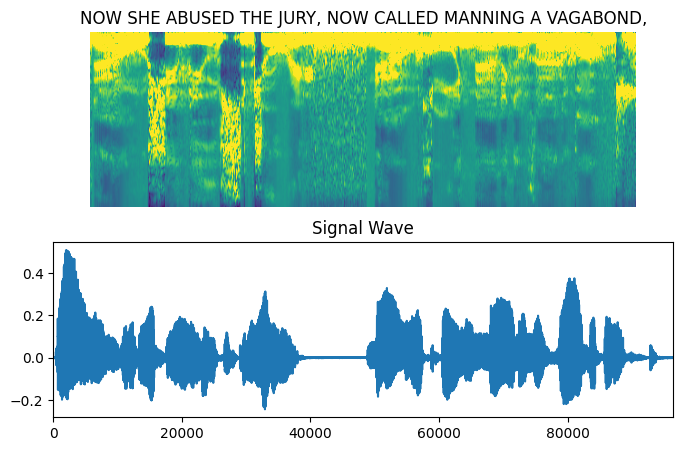

In [ ]:
# Change the number below (not greater than 5000 for good)
train_sample_index = 5

fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][train_sample_index].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][train_sample_index]

    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode('UTF-8')
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis('off')

    # WAV
    file_data = tf.io.read_file(list(train_metadata_df['file_name'])[train_sample_index])
    audio, _ = tf.audio.decode_wav(file_data)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title('Signal Wave')
    ax.set_xlim(0, len(audio))
    display(Audio(np.transpose(audio), rate=16_000))
plt.show()

In [ ]:
print(type(train_metadata_df['normalized_transcription'].iloc[0]))

<class 'str'>


## Model

We define the CTC loss function. To understand what it is, go [here](https://towardsdatascience.com/intuitively-understanding-connectionist-temporal-classification-3797e43a86c).

In [ ]:
def ctc_loss(target, prediction):
    '''
    Computes the loss value while training
    '''
    batch_size = tf.cast(tf.shape(target)[0], dtype='int64')
    input_size = tf.cast(tf.shape(prediction)[1], dtype='int64')
    label_size = tf.cast(tf.shape(target)[1], dtype='int64')

    temp = tf.ones(shape=(batch_size, 1), dtype='int64')
    input_size = input_size * temp
    label_size = label_size * temp

    loss = keras.backend.ctc_batch_cost(target, prediction, input_size, label_size)
    return loss

In [ ]:
def build_model(input_dim, output_dim, n_rnn_layers=5, n_rnn_units=128, lr=1e-4):
    '''
    A model similar to DeepSpeech 2
    '''

    # Input
    spectrogram = layers.Input((None, input_dim), name='input')

    # Expand the dimension using 2D Convolutional Neural Network
    x = layers.Reshape((-1, input_dim, 1), name='expand_dim')(spectrogram)

    # CNN Layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding='same',
        use_bias=False,
        name='conv_1'
    )(x)
    x = layers.BatchNormalization(name='conv_1_bn')(x)
    x = layers.ReLU(name='conv_1_relu')(x)

    # CNN Layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding='same',
        use_bias=False,
        name='conv_2'
    )(x)
    x = layers.BatchNormalization(name='conv_2_bn')(x)
    x = layers.ReLU(name='conv_2_relu')(x)

    # Reshape the resulted volume to feed the RNN layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)

    # RNN Layer
    for i in range(1, n_rnn_layers + 1):
        recurrent = layers.GRU(
            units=n_rnn_units,
            activation='tanh',
            recurrent_activation='sigmoid',
            use_bias='True',
            return_sequences=True,
            reset_after=True,
            name=f'gru_{i}'
        )
        x = layers.Bidirectional(
            recurrent, name=f'bidirectional_{i}', merge_mode='concat'
        )(x)
        if i != n_rnn_layers:
            x = layers.Dropout(rate=0.5)(x)

    # Dense Layer
    x = layers.Dense(units=n_rnn_units * 2, name='dense_1')(x)
    x = layers.ReLU(name='dense_1_relu')(x)
    x = layers.Dropout(rate=0.5)(x)

    # Classification Layer
    output = layers.Dense(units=output_dim + 1, activation='softmax')(x)

    # Model
    model = keras.Model(spectrogram, output, name='DeepSpeech_2')

    # Optimizer
    optim = keras.optimizers.Adam(learning_rate=lr)

    # Compile the model
    model.compile(optimizer=optim, loss=ctc_loss)
    return model

In [ ]:
model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    n_rnn_units=512
)
model.summary(line_length=100)

Model: "DeepSpeech_2"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 input (InputLayer)                          [(None, None, 193)]                     0              
                                                                                                    
 expand_dim (Reshape)                        (None, None, 193, 1)                    0              
                                                                                                    
 conv_1 (Conv2D)                             (None, None, 97, 32)                    14432          
                                                                                                    
 conv_1_bn (BatchNormalization)              (None, None, 97, 32)                    128            
                                                                     

## Train

In [ ]:
def decode_batch_predictions(predictions):
    input_length = np.ones(predictions.shape[0]) * predictions.shape[1]

    # Use greedy search
    results = keras.backend.ctc_decode(predictions, input_length=input_length, greedy=True)[0][0]

    # Iterate over the results and get back the text
    output_texts = [
        tf.strings.reduce_join(num_to_char(result)).numpy().decode('UTF-8')
        for result in results
    ]
    return output_texts


class CallbackEvaluate(keras.callbacks.Callback):
    '''
    A callback class output a few transcriptions during training.
    Display a batch of outputs after each epoch.
    '''

    def __init__(self, dataset):
        super(CallbackEvaluate, self).__init__()

        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X, verbose=0)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = tf.strings.reduce_join(num_to_char(label)).numpy().decode('UTF-8')
                targets.append(label)

        wer_score = jiwer.wer(targets, predictions)
        print('-' * 79)
        print(f'WER: {wer_score:.2%}')
        for i in np.random.randint(0, len(predictions), 2):
            print(f'Target    : {targets[i]}')
            print(f'Prediction: {predictions[i]}')
        print('-' * 79)


Phải train từ 50 đến 100 epoch thì kết quả mới dùng được, cái này chạy chơi 2 epoch lấy mùi thôi.

In [ ]:
# # Number of epochs
# n_epochs = 25

# # Callback function called on the testing dataset
# valid_callback = CallbackEvaluate(valid_dataset)

# # Train the model
# history = model.fit(
#     train_dataset,
#     validation_data=valid_dataset,
#     epochs=n_epochs,
#     callbacks=[valid_callback]
# )

In [ ]:
# Number of epochs
n_epochs = 100

# Callback function called on the testing dataset
valid_callback = CallbackEvaluate(valid_dataset)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=n_epochs,
    callbacks=[valid_callback]
)

Epoch 1/100
328/328 [==============================] - ETA: 0s - loss: 313.8702-------------------------------------------------------------------------------
WER: 100.00%
Target    : AT THE PRICE SOLOMONS HAD PAID FOR IT, AND IT COST HIM ABOUT A HUNDRED POUNDS TO RE-STOCK HIS SHOP WITH HIS OWN GOODS.
Prediction: 
Target    : THE PRESENCE OF THE BAG IN THIS CORNER IS COGENT EVIDENCE THAT IT WAS USED AS THE CONTAINER FOR THE RIFLE.
Prediction: 
-------------------------------------------------------------------------------
328/328 [==============================] - 750s 2s/step - loss: 313.8702 - val_loss: 376.8105
Epoch 2/100
328/328 [==============================] - ETA: 0s - loss: 230.9717-------------------------------------------------------------------------------
WER: 93.48%
Target    : THE OTHER OFFICERS WHO HELPED SUBDUE OSWALD CORROBORATED MCDONALD IN HIS TESTIMONY
Prediction: THE THER ISERS TMSL RRRT M  IN ISTSTM
Target    : IN ONE ROOM MR. NEILD FOUND A WOMAN ILL OF A FLUX 

KeyboardInterrupt: ignored

## Inference

In [ ]:
predictions = []
targets = []
for batch in test_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode('UTF-8')
        targets.append(label)

wer_score = jiwer.wer(targets, predictions)
print(f'WER: {wer_score:.2%}')
for i in np.random.randint(0, len(predictions), 2):
    print(f'Target    : {targets[i]}\n')
    print(f'Prediction: {predictions[i]}\n')
print('-' * 79)

In [ ]:
model.save('/content/drive/My Drive/model-doan-epoch100.keras')
# To load saved model,
# model = keras.models.load_model(<filename>)